Prices count: 5041, Time deltas count: 60


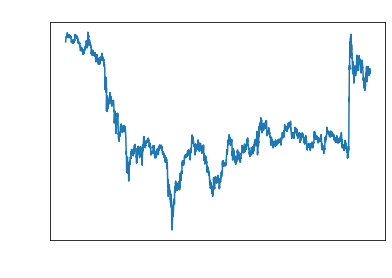

In [145]:
import os
from itertools import cycle
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import time
from binance import Client

import mmar

THEME_COLOR: Final = 'white'
SIMULATIONS_NUMBER: Final = 1000

def draw_plot(title: str, x, y:np.ndarray, xlabel:str, ylabel:str):
    plt.plot(x, y) if x is not None else plt.plot(y)
    plt.title(title, color=THEME_COLOR)
    plt.xlabel(xlabel, color=THEME_COLOR)
    plt.ylabel(ylabel, color=THEME_COLOR)
    plt.tick_params(colors=THEME_COLOR)

client = Client(os.getenv('BINANCE_API_KEY'), os.getenv('BINANCE_API_SECRET'))
# TODO: limit is ignored
klines = client.get_historical_klines(
    symbol="CHZUSDT",
    interval=Client.KLINE_INTERVAL_1MINUTE,
    start_str='7 Jun, 2021 10:00',
    end_str='10 Jun, 2021 22:00')
prices = np.array(list(map(float, [item[1] for item in klines])))
highly_composite_number = prices.size - 1
price_log_deltas_xt = np.log(prices) - np.log(prices[0])
time_deltas = mmar.get_time_deltas(highly_composite_number, prices)

draw_plot("Raw prices", np.arange(1, prices.size + 1), prices, 'Time', 'Price')
print(f'Prices count: {prices.size}, Time deltas count: {time_deltas.size}')

# get_time_deltas(highly_composite_number, prices)

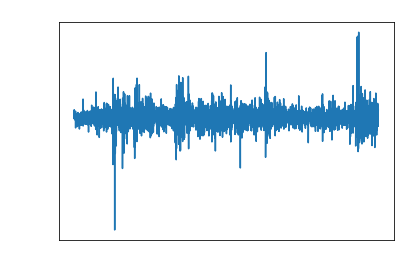

In [146]:
price_log_returns = [np.log(next_price/current_price) for current_price, next_price in zip(prices, prices[1:])]
draw_plot("Prices log-returns", np.arange(1, prices.size), price_log_returns, 'Time', 'Price change')

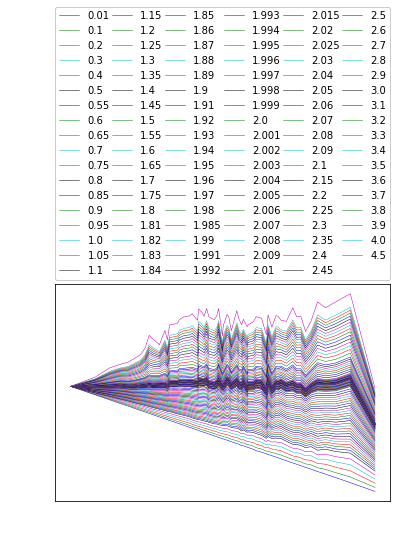

In [147]:
cycol = cycle('bgrcmk')

sample_sums = mmar.estimate_normalized_partition_function(time_deltas, price_log_deltas_xt)

for q in range (0, mmar.STAT_MOMENTS_Q.size):
    plt.plot(np.log(time_deltas), sample_sums[q],
             color=next(cycol),
             linewidth=0.5,
             label=str(mmar.STAT_MOMENTS_Q[q])
             )
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3,
           ncol=6,
           mode="expand",
           borderaxespad=0.,
           framealpha=1
           )
plt.xlabel('ln (delta_t)\n(the natural log of time increments)', color=THEME_COLOR)
plt.ylabel('ln ( Sq(delta_t) )\n(the natural log of the partition function)', color=THEME_COLOR)
plt.title("Partition function", color=THEME_COLOR)
plt.tick_params(colors=THEME_COLOR)

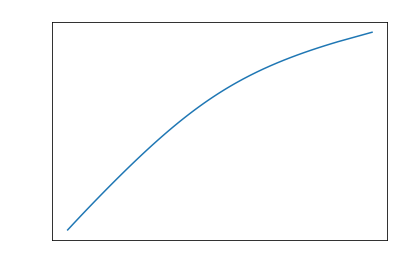

In [148]:
tau_q = mmar.estimate_scaling_function_tau_q(sample_sums, time_deltas, highly_composite_number)
draw_plot("Scaling function", mmar.STAT_MOMENTS_Q, tau_q, 'q', 'tau(q)')

In [149]:
b = 2

tau_q_polyfit = mmar.get_polyfit(tau_q)
a0 = mmar.get_holder_exponent_a(tau_q_polyfit)
h = mmar.get_hurst_exponent_h_mmar(tau_q_polyfit)
mean_lambda = a0 / h
sigma = (2 * (mean_lambda - 1)) / np.log(b)
print(f'Hurst: {h},\nHolder: {a0},\nLambda (mean): {mean_lambda},\nSigma (variance): {sigma} ')

Hurst: 0.4598481418313522,
Holder: 0.5975535881054753,
Lambda (mean): 1.2994585249941624,
Sigma (variance): 0.8640546579220035 


In [150]:
k = 12
simulation_range = b ** k
lognormal_cascade = mmar.estimate_lognormal_cascade(k, 1, mean_lambda, sigma).flatten()
draw_plot('Binomial Cascade',
          None,
          lognormal_cascade,
          'Conventional time',
          'Mass')

In [151]:
trading_time = mmar.get_trading_time(simulation_range, lognormal_cascade)
draw_plot('Trading time\n(normalized)',
          None,
          trading_time,
          'Conventional time',
          'Trading time')

In [152]:
fbm_simulation = mmar.get_fbm_simulation(simulation_range, h)
draw_plot('FBM simulation', None, fbm_simulation, 'Time', 'fBm (t)')

In [153]:
simulated_price_logs = mmar.simulate_price_logs(fbm_simulation, trading_time)
draw_plot('Price logs simulation', None, simulated_price_logs, 'Time', 'Price log')

In [154]:
simulated_prices = [prices[0] * np.exp(pl) for pl in simulated_price_logs]
draw_plot('Price simulation', None, simulated_prices, 'Time', 'Price')

In [155]:
simulated_price_log_returns = [np.log(next_price/current_price) for current_price, next_price in zip(simulated_prices, simulated_prices[1:])]
draw_plot('Simulated price logs simulation', None, simulated_price_log_returns, 'Time', 'Price log')

In [156]:
start_time = time.time()
mmar_simulation_samples = mmar.get_mmar_simulation_samples(k, h, mean_lambda, sigma, SIMULATIONS_NUMBER)
print(time.time() - start_time)
samples_size = np.size(mmar_simulation_samples, 0)
for mmar_s in mmar_simulation_samples:
    draw_plot(f'{samples_size} MMAR generated price paths',
              None, mmar_s,
              'Time', 'Price')
plt.plot(price_log_deltas_xt, color="black", linewidth=2)

In [157]:
plt.title('Histogram of simulated final price logs', color=THEME_COLOR)
plt.xlabel("Final price change", color=THEME_COLOR)
plt.ylabel("Frequency", color=THEME_COLOR)
plt.tick_params(colors=THEME_COLOR)
last_prices = mmar_simulation_samples[:,-1]
plt.hist(last_prices, bins=50, color="gray")
plt.axvline(np.quantile(last_prices, 0.05), linestyle='--', color="purple", label="5th percentile")
plt.axvline(np.quantile(last_prices, 0.25), linestyle='--', color="blue", label="25th percentile")
plt.axvline(np.quantile(last_prices, 0.50), linestyle='--', color="forestgreen", label="50th percentile")
plt.axvline(np.quantile(last_prices, 0.75), linestyle='--', color="gold", label="75th percentile")
plt.axvline(np.quantile(last_prices, 0.95), linestyle='--', color="red", label="95th percentile")
plt.axvline(price_log_deltas_xt[-1], linestyle='--', color="black", label="real final price", linewidth=0.7)
plt.legend()

In [158]:
print(np.mean(price_log_deltas_xt))

print(np.mean(mmar_simulation_samples))
print(np.median(mmar_simulation_samples))
print(np.quantile(last_prices, 0.50))